In [3]:
import tensorflow as tf
import jieba
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from opencc import OpenCC
import unicodedata
import re
import numpy as np
import os
import io
import time

# 下载和准备数据集
我们将使用 http://www.manythings.org/anki/ 提供的一个语言数据集。这个数据集包含如下格式的语言翻译对：

I love cake.	我鐘意蛋糕。\
这个数据集中有很多种语言可供选择。我们将使用英语 - 粤语数据集。下载完数据集后，我们将采取下列步骤准备数据：

给每个句子添加一个 开始 和一个 结束 标记（token）。\
预处理语料。\
创建一个单词索引和一个反向单词索引（即一个从单词映射至 id 的词典和一个从 id 映射至单词的词典）。\
将每个句子填充（pad）到最大长度。

In [187]:
# 文件路径

path_to_file = "cmn.txt"

In [188]:
# 定义繁简转换器

cc = OpenCC('t2s')

In [189]:
jieba.lcut("返工返成點呀？")

['返工', '返成點', '呀', '？']

In [190]:
def preprocess_sentence(w):
    # 英文转小写
    w = w.lower().strip()
    # 中文繁简转换
    w = cc.convert(w)
    w = w.rstrip().strip()
    # 分词
    w = ' '.join(jieba.lcut(w))
    # 去除多余空格
    w = re.sub(r'[" "]+', " ", w)
    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [191]:
en_sentence = u"Please be ready in fifteen minutes."
cn_sentence = u"有咩幫到你呢？"
# cn_sentence = u"有什么可以帮到你呢？"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(cn_sentence))

<start> please be ready in fifteen minutes . <end>
<start> 有 咩 帮到 你 呢 ？ <end>


In [192]:
# 2. 清理句子
# 3. 返回这样格式的句子对：[ENGLISH, CHINESE]
def create_dataset(path):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines]

    return zip(*word_pairs)

In [193]:
en, cn = create_dataset(path_to_file)
print(en[-1])
print(cn[-1])

<start> if a person has not had a chance to acquire his target language by the time he ' s an adult , he ' s unlikely to be able to reach native speaker level in that language . <end>
<start> 如果 一个 人 在 成人 前 没有 机会 习得 目标语言 ， 他 对 该 语言 的 认识 达到 母语 者 程度 的 机会 是 相当 小 的 。 <end>


In [194]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [195]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [196]:
def load_dataset(path):
    # 创建清理过的输入输出对
    targ_lang, inp_lang = create_dataset(path)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [197]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [198]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

18755 18755 4689 4689


In [199]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [200]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
7 ----> 你
91 ----> 为什么
344 ----> 打开
25 ----> 这个
856 ----> 盒子
9 ----> ？
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
110 ----> why
59 ----> did
8 ----> you
256 ----> open
6 ----> the
510 ----> box
10 ----> ?
2 ----> <end>


# 创建一个 tf.data 数据集

In [201]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

In [202]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [203]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 30]), TensorShape([64, 40]))

# 编写编码器 （encoder） 和解码器 （decoder） 模型

编码器采用 Bahdanau 注意力。在用简化形式编写之前，让我们先决定符号：

FC = 完全连接（密集）层\
EO = 编码器输出\
H = 隐藏层状态\
X = 解码器输入\
以及伪代码：

score = FC(tanh(FC(EO) + FC(H)))\
attention weights = softmax(score, axis = 1)。 \
Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 第一个轴, 因为分数 （score） 的形状是 (批大小，最大长度，1)。\
最大长度 （max_length） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。\
context vector = sum(attention weights * EO, axis = 1)。选择第一个轴的原因同上。\
embedding output = 解码器输入 X 通过一个嵌入层。\
merged vector = concat(embedding output, context vector)\
此合并后的向量随后被传送到 GRU
每个步骤中所有向量的形状已在代码的注释中阐明：

In [204]:
class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [205]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 30, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [206]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 隐藏层的形状 == （批大小，隐藏层大小）
        # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
        # 这样做是为了执行加法以计算分数
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，隐层大小）
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [207]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 30, 1)


In [208]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 用于注意力
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        x = self.embedding(x)

        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        x = self.fc(output)

        return x, state, attention_weights

In [209]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6532)


# 定义优化器和损失函数

In [210]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# 检查点（基于对象保存）

In [211]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# 训练
将 输入 传送至 编码器，编码器返回 编码器输出 和 编码器隐藏层状态。

将编码器输出、编码器隐藏层状态和解码器输入（即 开始标记）传送至解码器。

解码器返回 预测 和 解码器隐藏层状态。

解码器隐藏层状态被传送回模型，预测被用于计算损失。

使用 强制教学 （teacher forcing） 决定解码器的下一个输入。

强制教学 是将 目标词 作为 下一个输入 传送至解码器的技术。

最后一步是计算梯度，并将其应用于优化器和反向传播。

In [214]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [215]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0315
Epoch 1 Batch 100 Loss 1.0228
Epoch 1 Batch 200 Loss 0.8622
Epoch 1 Loss 1.0171
Time taken for 1 epoch 4109.3671243190765 sec

Epoch 2 Batch 0 Loss 0.8127
Epoch 2 Batch 100 Loss 0.7867
Epoch 2 Batch 200 Loss 0.7654
Epoch 2 Loss 0.7740
Time taken for 1 epoch 13567.209409952164 sec

Epoch 3 Batch 0 Loss 0.6483
Epoch 3 Batch 100 Loss 0.5868
Epoch 3 Batch 200 Loss 0.5996
Epoch 3 Loss 0.6351
Time taken for 1 epoch 2344.6578969955444 sec

Epoch 4 Batch 0 Loss 0.5297
Epoch 4 Batch 100 Loss 0.5030
Epoch 4 Batch 200 Loss 0.4637
Epoch 4 Loss 0.5150
Time taken for 1 epoch 2171.951658964157 sec

Epoch 5 Batch 0 Loss 0.3946
Epoch 5 Batch 100 Loss 0.4183
Epoch 5 Batch 200 Loss 0.4017
Epoch 5 Loss 0.4071
Time taken for 1 epoch 2142.007968902588 sec

Epoch 6 Batch 0 Loss 0.3160
Epoch 6 Batch 100 Loss 0.2699
Epoch 6 Batch 200 Loss 0.3401
Epoch 6 Loss 0.3141
Time taken for 1 epoch 2697.31707072258 sec

Epoch 7 Batch 0 Loss 0.2661
Epoch 7 Batch 100 Loss 0.2424
Epoch 7 Batch 20

# 翻译
评估函数类似于训练循环，不同之处在于在这里我们不使用 教师强制。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。\
当模型预测 结束标记 时停止预测。\
存储 每个时间步的注意力权重。\
请注意：对于一个输入，编码器输出仅计算一次。

In [216]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
    
        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
    
        predicted_id = tf.argmax(predictions[0]).numpy()
    
        result += targ_lang.index_word[predicted_id] + ' '
    
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
    
        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, sentence, attention_plot

In [217]:
# matplotlib显示中文
# !wget -O /Users/bob/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib as mpl
# zhfont = mpl.font_manager.FontProperties(fname='simhei.ttf')
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [218]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [219]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [220]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> 你 会 说 英语 么 ？ <end>
Predicted translation: do you speak english ? <end> 


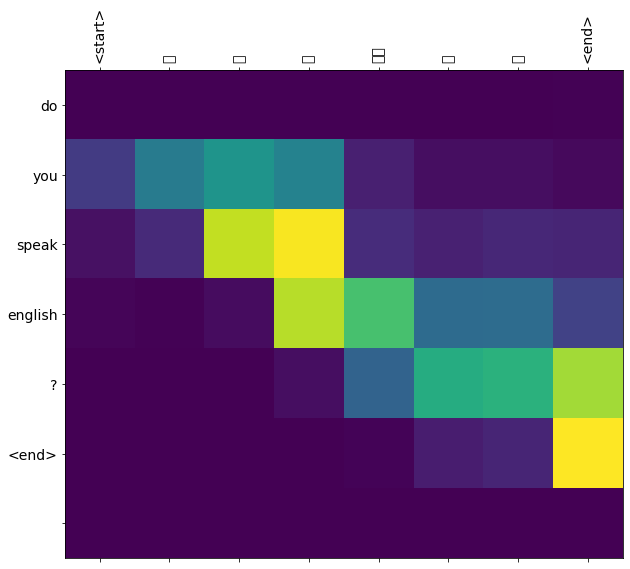

In [223]:
translate(u'你会说英语么？')

Input: <start> 我 知道 那些 夏天 就 像 你 一样 不 回来 。 <end>
Predicted translation: i know those stay well . <end> 


/Users/bob/opt/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/bob/opt/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30693 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/bob/opt/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36947 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/bob/opt/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37027 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/bob/opt/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20123 missing from current font.
  font.set_text(s, 0.0, flags=fl

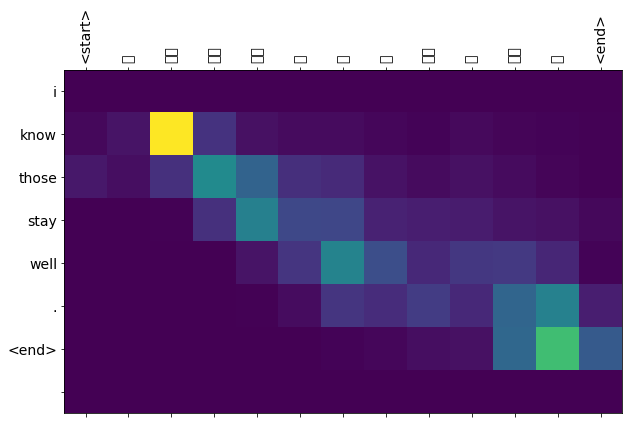

In [228]:
translate(u'我知道那些夏天就像你一样不回来。')

Input: <start> 没 问题 。 <end>
Predicted translation: no problem . <end> 


/Users/bob/opt/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27809 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/bob/opt/anaconda3/envs/TensorFlow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27809 missing from current font.
  font.set_text(s, 0, flags=flags)


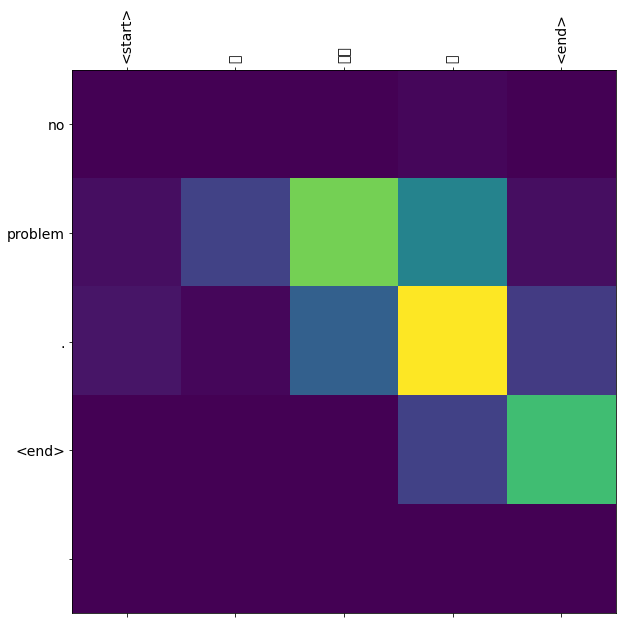

In [225]:
translate(u'没問題。')